Original data shape: (48842, 15)
Data shape after preprocessing: (46720, 11)
Remaining columns: ['age', 'workclass', 'educational-num', 'occupation', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

🔍 ANALYZING FEATURE CORRELATIONS
Correlation of features with income:
income             1.000000
educational-num    0.340633
age                0.261004
hours-per-week     0.229230
capital-gain       0.221597
gender             0.220969
capital-loss       0.150158
race               0.071893
occupation         0.051793
workclass          0.015699
native-country    -0.000615
Name: income, dtype: float64

🤖 TRAINING MODEL WITHOUT RELATIONSHIP & MARITAL-STATUS
Feature matrix shape: (46720, 10)
Features used: ['age', 'workclass', 'educational-num', 'occupation', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Training model...
Model accuracy: 0.8519

📈 MODEL EVALUATION

Classification Report:
              pr

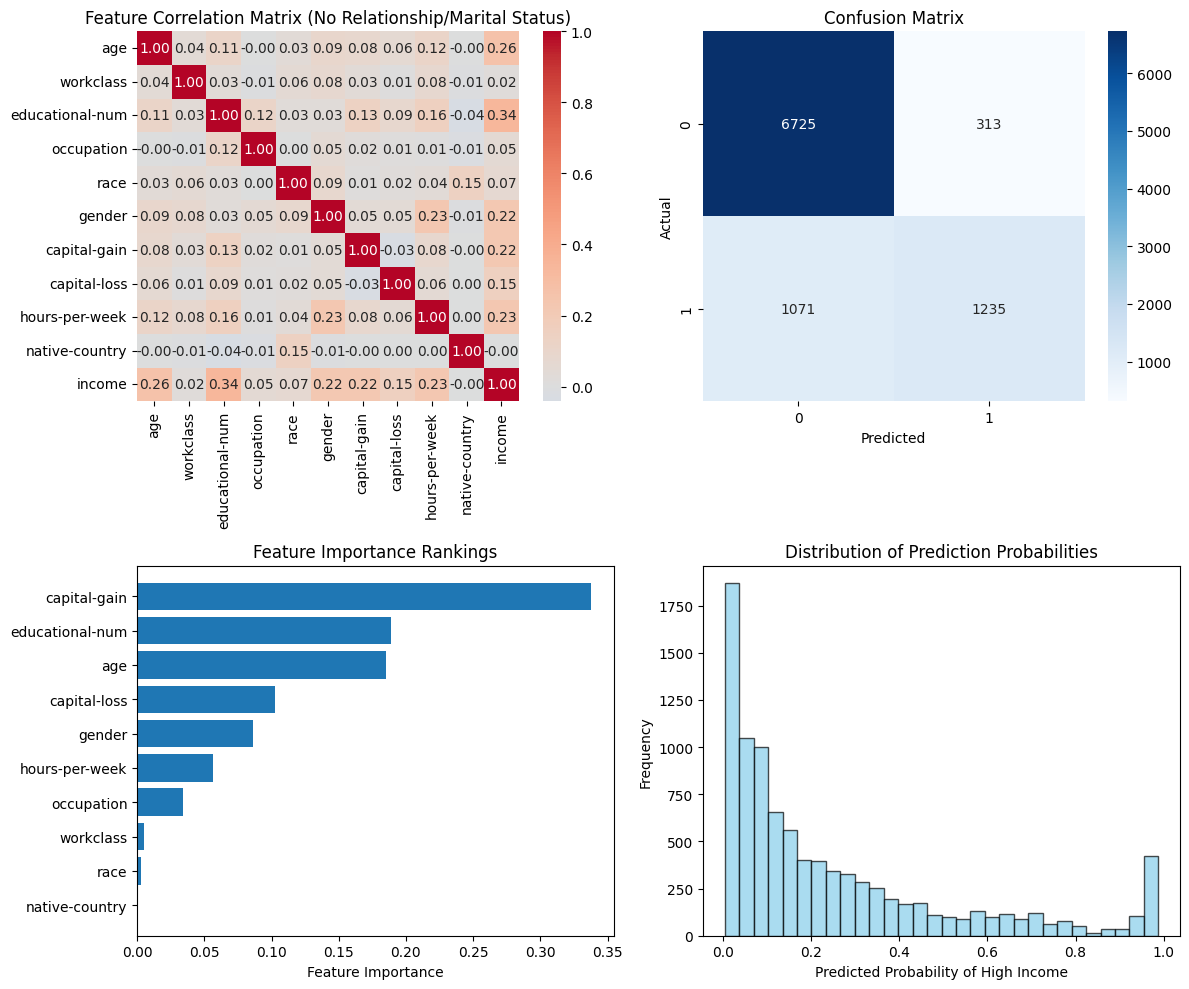


Top 5 Most Important Features:
capital-gain         : 0.3380
educational-num      : 0.1892
age                  : 0.1854
capital-loss         : 0.1024
gender               : 0.0861

⚖️ FAIRNESS CHECK
✅ REMOVED BIAS-PRONE FEATURES:
   - relationship (removed)
   - marital-status (removed)

✅ REMAINING LEGITIMATE PREDICTORS:
   - Educational level
   - Occupation type
   - Age (work experience proxy)
   - Hours worked per week
   - Work class
   - Capital gain/loss

🎯 FINAL MODEL PERFORMANCE:
   - Accuracy: 0.8519
   - Cross-val mean: 0.8467
   - Features used: 10
   - Most important feature: capital-gain

💾 Model saved as 'adult_income_model_clean.pkl'

🏁 TRAINING COMPLETE!


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data (same as your original code)
data = pd.read_csv("/content/drive/MyDrive/adult 3 (1).csv")  # Update path
print(f"Original data shape: {data.shape}")

# Basic preprocessing
data.workclass.replace({'?': 'Others'}, inplace=True)
data.occupation.replace({'?': 'Others'}, inplace=True)
data = data[data['workclass'] != 'Without-pay']
data = data[data['workclass'] != 'Never-worked']
data = data[(data['age'] <= 75) & (data['age'] >= 17)]
data = data[(data['educational-num'] <= 16) & (data['educational-num'] >= 5)]

# MODIFIED: Drop education, fnlwgt, relationship, AND marital-status
data = data.drop(columns=['education', 'fnlwgt', 'relationship', 'marital-status'])

print(f"Data shape after preprocessing: {data.shape}")
print(f"Remaining columns: {list(data.columns)}")

# =============================================================================
# FEATURE CORRELATION ANALYSIS
# =============================================================================
print("\n🔍 ANALYZING FEATURE CORRELATIONS")
print("="*50)

# Encode all categorical variables for correlation analysis
data_encoded = data.copy()
encoder = LabelEncoder()
categorical_columns = ['workclass', 'occupation', 'race', 'gender', 'native-country', 'income']

for col in categorical_columns:
    data_encoded[col] = encoder.fit_transform(data_encoded[col])

# Calculate correlation matrix
correlation_matrix = data_encoded.corr()

# Display correlation matrix
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix (No Relationship/Marital Status)')

# Show correlations with income
income_corr = correlation_matrix['income'].sort_values(ascending=False)
print("Correlation of features with income:")
print(income_corr)

# =============================================================================
# MAIN MODEL TRAINING (WITHOUT RELATIONSHIP AND MARITAL-STATUS)
# =============================================================================
print("\n🤖 TRAINING MODEL WITHOUT RELATIONSHIP & MARITAL-STATUS")
print("="*50)

# Prepare data for modeling
data_model = data.copy()

# Encode categorical variables
categorical_columns_final = ['workclass', 'occupation', 'race', 'gender', 'native-country']

for col in categorical_columns_final:
    data_model[col] = encoder.fit_transform(data_model[col])

# Split features and target
X = data_model.drop(columns=['income'])
y = data_model['income']

# Encode target if needed
if not set(np.unique(y)).issubset({0, 1}):
    y = encoder.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {list(X.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

print("Training model...")
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy:.4f}")

# =============================================================================
# MODEL EVALUATION
# =============================================================================
print("\n📈 MODEL EVALUATION")
print("="*50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Cross-validation score
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n🎯 FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importances
feature_importance = gb_model.feature_importances_
feature_names = X.columns.tolist()

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
print(importance_df.to_string(index=False))

# Plot feature importance
plt.subplot(2, 2, 3)
indices = np.argsort(feature_importance)[::-1]
top_features = min(len(feature_importance), len(feature_names))
plt.barh(range(top_features), feature_importance[indices[:top_features]])
plt.yticks(range(top_features), [feature_names[i] for i in indices[:top_features]])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Rankings')
plt.gca().invert_yaxis()

# =============================================================================
# MODEL INSIGHTS
# =============================================================================
print("\n💡 MODEL INSIGHTS")
print("="*50)

plt.subplot(2, 2, 4)
# Show distribution of predictions
pred_proba = gb_model.predict_proba(X_test)
plt.hist(pred_proba[:, 1], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probability of High Income')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities')

plt.tight_layout()
plt.show()

# Top 5 most important features
top_5_features = importance_df.head().copy()
print(f"\nTop 5 Most Important Features:")
for idx, row in top_5_features.iterrows():
    print(f"{row['Feature']:20} : {row['Importance']:.4f}")

# =============================================================================
# FAIRNESS AND BIAS CHECK
# =============================================================================
print("\n⚖️ FAIRNESS CHECK")
print("="*50)
print("✅ REMOVED BIAS-PRONE FEATURES:")
print("   - relationship (removed)")
print("   - marital-status (removed)")
print("\n✅ REMAINING LEGITIMATE PREDICTORS:")
print("   - Educational level")
print("   - Occupation type")
print("   - Age (work experience proxy)")
print("   - Hours worked per week")
print("   - Work class")
print("   - Capital gain/loss")

print(f"\n🎯 FINAL MODEL PERFORMANCE:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - Cross-val mean: {cv_scores.mean():.4f}")
print(f"   - Features used: {len(X.columns)}")
print(f"   - Most important feature: {importance_df.iloc[0]['Feature']}")

# Save model (optional)
import joblib
try:
    joblib.dump(gb_model, 'adult_income_model_clean.pkl')
    print(f"\n💾 Model saved as 'adult_income_model_clean.pkl'")
except:
    print(f"\n⚠️ Could not save model - check write permissions")

print("\n🏁 TRAINING COMPLETE!")
print("="*50)

In [44]:
!pip install streamlit

In [45]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Page configuration
st.set_page_config(
    page_title="💼 Smart Salary Predictor",
    page_icon="💼",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Load the trained model and create encoders
@st.cache_resource
def load_model_and_create_encoders():
    try:
        model = joblib.load("/content/adult_income_model_clean.pkl")

        # Create label encoders for categorical variables
        # These mappings should match your training data preprocessing
        categorical_encoders = {}

        # Create mappings based on typical Adult dataset values (removed relationship and marital-status)
        categorical_mappings = {
            'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov',
                         'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
            'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales',
                          'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners',
                          'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing',
                          'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
            'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
            'gender': ['Male', 'Female'],
            'native-country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany',
                              'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China',
                              'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica',
                              'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic',
                              'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala',
                              'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador',
                              'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']
        }

        # Create and fit label encoders
        for column, values in categorical_mappings.items():
            encoder = LabelEncoder()
            encoder.fit(values)
            categorical_encoders[column] = encoder

        return model, categorical_encoders

    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None, None

def preprocess_input(input_data, categorical_encoders):
    """Preprocess input data to match training data format"""
    processed_data = input_data.copy()

    # Encode categorical variables
    for column, encoder in categorical_encoders.items():
        if column in processed_data.columns:
            try:
                processed_data[column] = encoder.transform(processed_data[column])
            except ValueError as e:
                st.error(f"Unknown category in {column}: {e}")
                # Use the first category as default
                processed_data[column] = 0

    return processed_data

# Feature interpretation function (removed relationship and marital-status)
def get_feature_interpretation(feature_name, shap_value):
    """Convert technical feature names to actionable insights"""

    interpretations = {
        'age': {
            'positive': "Experience and seniority boost your income potential",
            'negative': "Consider leveraging experience or exploring age-friendly sectors"
        },
        'educational-num': {
            'positive': "Your education level strongly supports higher income",
            'negative': "💡 **Priority**: Pursue additional education, certifications, or training"
        },
        'hours-per-week': {
            'positive': "Your work hours contribute positively to income",
            'negative': "Consider increasing work hours if work-life balance allows"
        },
        'occupation': {
            'positive': "Your occupation has strong earning potential",
            'negative': "💼 **Consider**: Career transition to higher-paying field"
        },
        'workclass': {
            'positive': "Your employment type supports higher income",
            'negative': "Consider private sector or government opportunities"
        },
        'capital-gain': {
            'positive': "🎉 **Strength**: Investment income significantly boosts earnings",
            'negative': "💰 **Opportunity**: Build investment portfolio or income-generating assets"
        },
        'capital-loss': {
            'positive': "Low investment losses help maintain net income",
            'negative': "⚠️ Consider reviewing investment strategy to minimize losses"
        },
        'gender': {
            'positive': "Gender factor works in your favor",
            'negative': "Focus on skill development and negotiation to overcome pay gaps"
        },
        'race': {
            'positive': "Demographic factors are favorable",
            'negative': "Focus on skill-based advancement and networking"
        },
        'native-country': {
            'positive': "Your country of origin is favorable for income",
            'negative': "Focus on skill-based advancement and networking"
        }
    }

    impact_type = 'positive' if shap_value > 0 else 'negative'

    if feature_name in interpretations:
        return interpretations[feature_name][impact_type]
    else:
        clean_name = feature_name.replace('-', ' ').replace('_', ' ').title()
        if impact_type == 'positive':
            return f"{clean_name} is working in your favor"
        else:
            return f"Consider improving {clean_name.lower()} for better income potential"

# Initialize SHAP explainer
@st.cache_resource
def initialize_shap_explainer(_model):
    """Initialize SHAP explainer for the model"""
    try:
        explainer = shap.TreeExplainer(_model)
        return explainer
    except Exception as e:
        st.error(f"Error initializing SHAP: {e}")
        return None

# Education mapping
EDUCATION_MAPPING = {
    "Preschool": 1, "1st-4th": 2, "5th-6th": 3, "7th-8th": 4, "9th": 5, "10th": 6,
    "11th": 7, "12th": 8, "HS-grad": 9, "Some-college": 10, "Assoc-voc": 11,
    "Assoc-acdm": 12, "Bachelors": 13, "Masters": 14, "Prof-school": 15, "Doctorate": 16
}

# Main app
def main():
    # Header
    st.title("💼 Smart Salary Predictor with AI Insights")
    st.markdown("### Predict salary class and get personalized recommendations to increase your income!")

    # Load model and encoders
    model, categorical_encoders = load_model_and_create_encoders()
    if model is None or categorical_encoders is None:
        st.error("Failed to load model or create encoders. Please check your model file.")
        st.stop()

    # Initialize SHAP
    explainer = initialize_shap_explainer(model)

    # Create tabs
    tab1, tab2, tab3 = st.tabs(["🔮 Prediction", "📊 Feature Analysis", "📁 Batch Prediction"])

    with tab1:
        # Two columns layout
        col1, col2 = st.columns([1, 1])

        with col1:
            st.header("📝 Input Details")

            # Input fields - matching the expected features (removed relationship and marital-status)
            age = st.slider("Age", 17, 90, 39)

            education = st.selectbox("Education Level", [
                "Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th",
                "HS-grad", "Some-college", "Assoc-voc", "Assoc-acdm", "Bachelors",
                "Masters", "Prof-school", "Doctorate"
            ], index=12)  # Default to Bachelors

            # Convert education to numerical value
            educational_num = EDUCATION_MAPPING[education]

            occupation = st.selectbox("Occupation", [
                "Tech-support", "Craft-repair", "Other-service", "Sales",
                "Exec-managerial", "Prof-specialty", "Handlers-cleaners",
                "Machine-op-inspct", "Adm-clerical", "Farming-fishing",
                "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces"
            ])

            workclass = st.selectbox("Work Class", [
                "Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov",
                "Local-gov", "State-gov", "Without-pay", "Never-worked"
            ])

            race = st.selectbox("Race", [
                "White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"
            ])

            gender = st.selectbox("Gender", ["Male", "Female"])

            native_country = st.selectbox("Native Country", [
                "United-States", "Cambodia", "England", "Puerto-Rico", "Canada", "Germany",
                "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece", "South", "China",
                "Cuba", "Iran", "Honduras", "Philippines", "Italy", "Poland", "Jamaica",
                "Vietnam", "Mexico", "Portugal", "Ireland", "France", "Dominican-Republic",
                "Laos", "Ecuador", "Taiwan", "Haiti", "Columbia", "Hungary", "Guatemala",
                "Nicaragua", "Scotland", "Thailand", "Yugoslavia", "El-Salvador",
                "Trinadad&Tobago", "Peru", "Hong", "Holand-Netherlands"
            ])

            hours_per_week = st.slider("Hours per Week", 1, 99, 40)

            # Additional features
            capital_gain = st.number_input("Capital Gain", 0, 100000, 0)
            capital_loss = st.number_input("Capital Loss", 0, 10000, 0)

        with col2:
            st.header("🎯 Prediction Results")

            # Create input dataframe with correct feature names (removed relationship and marital-status)
            input_data = pd.DataFrame({
                'age': [age],
                'workclass': [workclass],
                'educational-num': [educational_num],
                'occupation': [occupation],
                'race': [race],
                'gender': [gender],
                'capital-gain': [capital_gain],
                'capital-loss': [capital_loss],
                'hours-per-week': [hours_per_week],
                'native-country': [native_country]
            })

            if st.button("🚀 Predict Salary", type="primary"):
                try:
                    # Preprocess input data
                    processed_data = preprocess_input(input_data, categorical_encoders)

                    # Make prediction
                    prediction = model.predict(processed_data)[0]
                    probability = model.predict_proba(processed_data)[0]

                    # Display prediction
                    if prediction == 1:  # Assuming 1 means >50K
                        st.success("✅ **Predicted Salary: >$50K**")
                        prob_high = probability[1]
                    else:
                        st.warning("⚠️ **Predicted Salary: ≤$50K**")
                        prob_high = probability[1]

                    st.info(f"**Confidence for >50K:** {prob_high:.1%}")

                    # Progress bar for probability
                    st.progress(prob_high)

                    # SHAP Analysis
                    if explainer is not None:
                        st.subheader("🧠 AI Insights & Recommendations")

                        try:
                            # Calculate SHAP values
                            shap_values = explainer.shap_values(processed_data)

                            # Handle binary classification SHAP output
                            if isinstance(shap_values, list):
                                shap_vals = shap_values[1][0]  # Positive class
                            else:
                                shap_vals = shap_values[0]

                            # Get feature names
                            feature_names = processed_data.columns.tolist()

                            # Create SHAP analysis
                            feature_impact = pd.DataFrame({
                                'Feature': feature_names,
                                'Impact': shap_vals,
                                'Abs_Impact': np.abs(shap_vals)
                            }).sort_values('Abs_Impact', ascending=False)

                            # Top contributing features
                            st.write("**🎯 Top Factors Affecting Your Salary:**")

                            for i, row in feature_impact.head(5).iterrows():
                                impact_strength = "🔥" if row['Abs_Impact'] > 0.1 else "📊" if row['Abs_Impact'] > 0.05 else "📈"
                                direction = "↗️" if row['Impact'] > 0 else "↘️"

                                with st.expander(f"{impact_strength} {direction} {row['Feature'].replace('-', ' ').title()} (Impact: {row['Impact']:+.3f})"):
                                    interpretation = get_feature_interpretation(row['Feature'], row['Impact'])
                                    st.write(interpretation)

                            # Improvement recommendations
                            improvement_ops = feature_impact[feature_impact['Impact'] < -0.02].head(3)
                            strengths = feature_impact[feature_impact['Impact'] > 0.02].head(3)

                            if len(improvement_ops) > 0:
                                st.subheader("🔧 Priority Improvements")
                                for i, row in improvement_ops.iterrows():
                                    st.write(f"• {get_feature_interpretation(row['Feature'], row['Impact'])}")

                            if len(strengths) > 0:
                                st.subheader("💪 Your Strengths")
                                for i, row in strengths.iterrows():
                                    st.write(f"• {get_feature_interpretation(row['Feature'], row['Impact'])}")

                        except Exception as shap_error:
                            st.warning(f"SHAP analysis unavailable: {shap_error}")

                except Exception as e:
                    st.error(f"Prediction error: {e}")
                    st.error("Please check that all required features are provided.")
                    # Debug info
                    st.write("**Debug Info:**")
                    st.write("Processed data types:")
                    st.write(processed_data.dtypes)
                    st.write("Processed data sample:")
                    st.write(processed_data)

    with tab2:
        st.header("📊 Feature Impact Analysis")

        # Sample data analysis
        st.info("This section shows general feature importance from the model training.")

        # Feature importance plot
        if hasattr(model, 'feature_importances_'):
            try:
                st.subheader("🎯 General Feature Importance")

                # Expected feature names (removed relationship and marital-status)
                expected_features = ['age', 'workclass', 'educational-num', 'occupation',
                                   'race', 'gender', 'capital-gain', 'capital-loss',
                                   'hours-per-week', 'native-country']

                if len(model.feature_importances_) == len(expected_features):
                    importance_df = pd.DataFrame({
                        'Feature': expected_features,
                        'Importance': model.feature_importances_
                    }).sort_values('Importance', ascending=True)

                    # Create horizontal bar chart
                    fig = px.bar(importance_df,
                               x='Importance',
                               y='Feature',
                               orientation='h',
                               title="Feature Importance in Salary Prediction",
                               color='Importance',
                               color_continuous_scale='viridis')

                    fig.update_layout(height=500)
                    st.plotly_chart(fig, use_container_width=True)

                    # Top insights
                    st.subheader("🔍 Key Insights")
                    top_features = importance_df.tail(3)

                    for _, row in top_features.iterrows():
                        st.write(f"• **{row['Feature'].replace('-', ' ').title()}** is a major factor in salary determination")
                else:
                    st.warning(f"Feature count mismatch: Model has {len(model.feature_importances_)} features, expected {len(expected_features)}")

            except Exception as e:
                st.error(f"Error displaying feature importance: {e}")

    with tab3:
        st.header("📁 Batch Prediction")
        st.markdown("Upload a CSV file to predict salary classes for multiple employees.")

        # Show expected format (removed relationship and marital-status)
        st.subheader("📋 Expected CSV Format")
        sample_df = pd.DataFrame({
            'age': [39, 50, 38],
            'workclass': ['State-gov', 'Self-emp-not-inc', 'Private'],
            'educational-num': [13, 13, 9],
            'occupation': ['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners'],
            'race': ['White', 'White', 'White'],
            'gender': ['Male', 'Male', 'Male'],
            'capital-gain': [2174, 0, 0],
            'capital-loss': [0, 0, 0],
            'hours-per-week': [40, 13, 40],
            'native-country': ['United-States', 'United-States', 'United-States']
        })
        st.write(sample_df)

        uploaded_file = st.file_uploader("Choose a CSV file", type="csv")

        if uploaded_file is not None:
            try:
                batch_data = pd.read_csv(uploaded_file)
                st.write("**📋 Uploaded Data Preview:**")
                st.write(batch_data.head())

                # Check if all required columns are present (removed relationship and marital-status)
                required_columns = ['age', 'workclass', 'educational-num', 'occupation',
                                  'race', 'gender', 'capital-gain', 'capital-loss',
                                  'hours-per-week', 'native-country']

                missing_columns = [col for col in required_columns if col not in batch_data.columns]
                if missing_columns:
                    st.error(f"Missing required columns: {missing_columns}")
                else:
                    if st.button("🚀 Predict All", type="primary"):
                        # Preprocess batch data
                        processed_batch = preprocess_input(batch_data[required_columns], categorical_encoders)

                        # Make predictions
                        predictions = model.predict(processed_batch)
                        probabilities = model.predict_proba(processed_batch)

                        # Add results to dataframe
                        result_df = batch_data.copy()
                        result_df['Predicted_Salary_Class'] = ['High (>50K)' if p == 1 else 'Low (≤50K)' for p in predictions]
                        result_df['Confidence_High_Income'] = [f"{prob[1]:.1%}" for prob in probabilities]

                        st.success("✅ Predictions completed!")
                        st.write("**📊 Results:**")
                        st.write(result_df)

                        # Summary statistics
                        high_income_count = sum(predictions)
                        total_count = len(predictions)

                        col1, col2, col3 = st.columns(3)
                        with col1:
                            st.metric("Total Predictions", total_count)
                        with col2:
                            st.metric("High Income (>50K)", high_income_count)
                        with col3:
                            st.metric("Percentage High Income", f"{high_income_count/total_count:.1%}")

                        # Download results
                        csv = result_df.to_csv(index=False).encode('utf-8')
                        st.download_button(
                            "📥 Download Results",
                            csv,
                            file_name='salary_predictions.csv',
                            mime='text/csv'
                        )

            except Exception as e:
                st.error(f"Error processing file: {e}")

    # Footer
    st.markdown("---")
    st.markdown("**💡 Tips for Better Predictions:**")
    st.markdown("""
    - Ensure your input data matches the training data format exactly
    - All categorical variables are automatically encoded to match the training data
    - Higher education (educational-num) and specialized occupations typically increase income probability
    - Work experience (age) and hours per week are strong predictors
    - Investment income (capital gains) can significantly boost total earnings
    - Make sure all required columns are present in batch prediction files
    """)

if __name__ == "__main__":
    main()

Writing app.py
